In [18]:

import sys
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
import time
from collections import defaultdict

from path_trajectory_pkg.path_smoother import PathSmoother

print("✓ Imports successful")
print("✓ PathSmoother class loaded")
print()

# Initialize test results tracker
test_results = defaultdict(list)


✓ Imports successful
✓ PathSmoother class loaded



# Cell 2: Test Data Fixtures - Create Test Waypoints

In [19]:


class TestFixtures:
    
    @staticmethod
    def simple_square():
        """4-point square."""
        return np.array([
            [0.0, 0.0],
            [1.0, 0.0],
            [1.0, 1.0],
            [0.0, 1.0]
        ])
    
    @staticmethod
    def straight_line():
        """5 collinear points."""
        return np.array([
            [0.0, 0.0],
            [1.0, 0.0],
            [2.0, 0.0],
            [3.0, 0.0],
            [4.0, 0.0]
        ])
    
    @staticmethod
    def s_curve():
        """6-point S-curve."""
        return np.array([
            [0.0, 0.0],
            [1.0, 0.0],
            [2.0, 1.0],
            [3.0, 1.0],
            [4.0, 0.0],
            [5.0, 0.0]
        ])
    
    @staticmethod
    def right_angle_turn():
        """3-point 90-degree turn."""
        return np.array([
            [0.0, 0.0],
            [1.0, 0.0],
            [1.0, 1.0]
        ])
    
    @staticmethod
    def closed_loop():
        """Closed loop (start == end)."""
        return np.array([
            [0.0, 0.0],
            [1.0, 0.0],
            [1.0, 1.0],
            [0.0, 1.0],
            [0.0, 0.0]  # Back to start
        ])
    
    @staticmethod
    def real_robot_path():
        """Your actual bcr_bot waypoints."""
        return np.array([
            [0.0, 0.0],
            [0.374, -6.042],
            [-3.258, -5.959]
        ])
    
    @staticmethod
    def insufficient_points():
        """Only 2 points - should fail B-spline."""
        return np.array([
            [0.0, 0.0],
            [1.0, 1.0]
        ])
    
    @staticmethod
    def duplicate_points():
        """Contains duplicate waypoint."""
        return np.array([
            [0.0, 0.0],
            [1.0, 0.0],
            [1.0, 0.0],  # Duplicate
            [1.0, 1.0]
        ])

# Create fixture instances
fixtures = TestFixtures()

print("✓ Test fixtures created:")
print(f"  - simple_square: {len(fixtures.simple_square())} points")
print(f"  - straight_line: {len(fixtures.straight_line())} points")
print(f"  - s_curve: {len(fixtures.s_curve())} points")
print(f"  - right_angle_turn: {len(fixtures.right_angle_turn())} points")
print(f"  - closed_loop: {len(fixtures.closed_loop())} points")
print(f"  - real_robot_path: {len(fixtures.real_robot_path())} points")


✓ Test fixtures created:
  - simple_square: 4 points
  - straight_line: 5 points
  - s_curve: 6 points
  - right_angle_turn: 3 points
  - closed_loop: 5 points
  - real_robot_path: 3 points


# Cell 3: Helper Functions for Testing

In [8]:


def assert_close(actual, expected, tolerance=0.001, test_name="Test"):
    """Assert two values are close within tolerance."""
    if np.isclose(actual, expected, atol=tolerance):
        print(f"  ✅ {test_name}: PASS (expected={expected:.4f}, got={actual:.4f})")
        return True
    else:
        print(f"  ❌ {test_name}: FAIL (expected={expected:.4f}, got={actual:.4f})")
        return False

def assert_less_than(value, threshold, test_name="Test"):
    """Assert value is less than threshold."""
    if value < threshold:
        print(f"  ✅ {test_name}: PASS ({value:.4f} < {threshold:.4f})")
        return True
    else:
        print(f"  ❌ {test_name}: FAIL ({value:.4f} >= {threshold:.4f})")
        return False

def assert_greater_than(value, threshold, test_name="Test"):
    """Assert value is greater than threshold."""
    if value > threshold:
        print(f"  ✅ {test_name}: PASS ({value:.4f} > {threshold:.4f})")
        return True
    else:
        print(f"  ❌ {test_name}: FAIL ({value:.4f} <= {threshold:.4f})")
        return False

def record_result(category, test_name, passed):
    """Record test result."""
    test_results[category].append({'test': test_name, 'passed': passed})

print("✓ Helper functions loaded")


✓ Helper functions loaded


# Cell 4: Test compute_path_length() - Static Method

In [9]:
print("="*60)
print("TEST 1: compute_path_length()")
print("="*60)

# Test 1.1: Known distance (3-4-5 triangle)
print("\n[Test 1.1] Known distance (3-4-5 triangle)")
x = np.array([0.0, 3.0])
y = np.array([0.0, 4.0])
expected = 5.0
result = PathSmoother.compute_path_length(x, y)
passed = assert_close(result, expected, test_name="3-4-5 triangle")
record_result("Path Length", "Known distance", passed)

# Test 1.2: Single segment
print("\n[Test 1.2] Single segment (horizontal)")
x = np.array([0.0, 5.0])
y = np.array([0.0, 0.0])
expected = 5.0
result = PathSmoother.compute_path_length(x, y)
passed = assert_close(result, expected, test_name="Horizontal line")
record_result("Path Length", "Single segment", passed)

# Test 1.3: Multi-segment square
print("\n[Test 1.3] Multi-segment (unit square)")
waypoints = fixtures.simple_square()
x = waypoints[:, 0]
y = waypoints[:, 1]
expected = 3.0  # Three sides of unit square (not closed)
result = PathSmoother.compute_path_length(x, y)
passed = assert_close(result, expected, test_name="Unit square")
record_result("Path Length", "Multi-segment", passed)

# Test 1.4: Zero length (single point - edge case)
print("\n[Test 1.4] Zero length (single point)")
x = np.array([0.0])
y = np.array([0.0])
expected = 0.0
result = PathSmoother.compute_path_length(x, y)
passed = assert_close(result, expected, test_name="Single point")
record_result("Path Length", "Zero length", passed)

print("\n" + "="*60)
print("Path Length Tests Complete")
print("="*60)


TEST 1: compute_path_length()

[Test 1.1] Known distance (3-4-5 triangle)
  ✅ 3-4-5 triangle: PASS (expected=5.0000, got=5.0000)

[Test 1.2] Single segment (horizontal)
  ✅ Horizontal line: PASS (expected=5.0000, got=5.0000)

[Test 1.3] Multi-segment (unit square)
  ✅ Unit square: PASS (expected=3.0000, got=3.0000)

[Test 1.4] Zero length (single point)
  ✅ Single point: PASS (expected=0.0000, got=0.0000)

Path Length Tests Complete


# Cell 5: Test compute_curvature() - Static Method

In [10]:
print("="*60)
print("TEST 2: compute_curvature()")
print("="*60)

# Test 2.1: Straight line (curvature should be ~0)
print("\n[Test 2.1] Straight line (curvature ≈ 0)")
waypoints = fixtures.straight_line()
x = waypoints[:, 0]
y = waypoints[:, 1]

# Create B-spline
tck, u = splprep([x, y], s=0, k=3)
u_test = np.linspace(0, 1, 100)

# Compute curvature
curvatures = PathSmoother.compute_curvature(tck, u_test)
max_curvature = np.max(np.abs(curvatures))

passed = assert_less_than(max_curvature, 0.1, test_name="Straight line curvature")
record_result("Curvature", "Straight line", passed)

# Test 2.2: 90-degree turn (high curvature)
print("\n[Test 2.2] 90-degree turn (high curvature)")
waypoints = fixtures.right_angle_turn()
x = waypoints[:, 0]
y = waypoints[:, 1]

tck, u = splprep([x, y], s=0, k=2)  # k=2 for 3 points
u_test = np.linspace(0, 1, 100)

curvatures = PathSmoother.compute_curvature(tck, u_test)
max_curvature = np.max(np.abs(curvatures))

passed = assert_greater_than(max_curvature, 0.5, test_name="90° turn curvature")
record_result("Curvature", "Sharp turn", passed)

# Test 2.3: Curvature continuity (no sudden jumps)
print("\n[Test 2.3] Curvature continuity (smooth changes)")
waypoints = fixtures.s_curve()
x = waypoints[:, 0]
y = waypoints[:, 1]

tck, u = splprep([x, y], s=0, k=3)
u_test = np.linspace(0, 1, 100)

curvatures = PathSmoother.compute_curvature(tck, u_test)
curvature_changes = np.abs(np.diff(curvatures))
max_change = np.max(curvature_changes)

passed = assert_less_than(max_change, 1.0, test_name="Curvature continuity")
record_result("Curvature", "Continuity", passed)

# Test 2.4: Curvature sign validation (left vs right turns)
print("\n[Test 2.4] Curvature sign validation")
# Right turn should have negative curvature (or positive, depending on convention)
waypoints = np.array([[0.0, 0.0], [1.0, 0.0], [1.0, -1.0]])  # Right turn
x = waypoints[:, 0]
y = waypoints[:, 1]

tck, u = splprep([x, y], s=0, k=2)
u_test = np.linspace(0, 1, 50)

curvatures = PathSmoother.compute_curvature(tck, u_test)
# Check that most curvatures have consistent sign
positive_count = np.sum(curvatures > 0)
negative_count = np.sum(curvatures < 0)
dominant_sign_ratio = max(positive_count, negative_count) / len(curvatures)

passed = assert_greater_than(dominant_sign_ratio, 0.7, test_name="Consistent sign")
record_result("Curvature", "Sign validation", passed)

print("\n" + "="*60)
print("Curvature Tests Complete")
print("="*60)

TEST 2: compute_curvature()

[Test 2.1] Straight line (curvature ≈ 0)
  ✅ Straight line curvature: PASS (0.0000 < 0.1000)

[Test 2.2] 90-degree turn (high curvature)
  ✅ 90° turn curvature: PASS (2.8267 > 0.5000)

[Test 2.3] Curvature continuity (smooth changes)
  ✅ Curvature continuity: PASS (0.1312 < 1.0000)

[Test 2.4] Curvature sign validation
  ✅ Consistent sign: PASS (1.0000 > 0.7000)

Curvature Tests Complete


# Cell 6: Test Input Validation

In [12]:
print("="*60)
print("TEST 3: Input Validation")
print("="*60)

# Test 3.1: Valid waypoints (3+ points)
print("\n[Test 3.1] Valid waypoints (4 points)")
waypoints = fixtures.simple_square()
try:
    x = waypoints[:, 0]
    y = waypoints[:, 1]
    tck, u = splprep([x, y], s=0, k=3)
    print(f"  ✅ Valid waypoints: PASS ({len(waypoints)} points accepted)")
    record_result("Input Validation", "Valid waypoints", True)
except Exception as e:
    print(f"  ❌ Valid waypoints: FAIL - {e}")
    record_result("Input Validation", "Valid waypoints", False)

# Test 3.2: Insufficient waypoints (< 3 points for k=3)
print("\n[Test 3.2] Insufficient waypoints (2 points)")
waypoints = fixtures.insufficient_points()
try:
    x = waypoints[:, 0]
    y = waypoints[:, 1]
    tck, u = splprep([x, y], s=0, k=3)
    print(f"  ❌ Insufficient waypoints: FAIL (should have raised error)")
    record_result("Input Validation", "Insufficient points", False)
except Exception as e:
    print(f"  ✅ Insufficient waypoints: PASS (correctly rejected)")
    record_result("Input Validation", "Insufficient points", True)

# Test 3.3: Duplicate waypoints
print("\n[Test 3.3] Duplicate waypoints")
waypoints = fixtures.duplicate_points()
try:
    x = waypoints[:, 0]
    y = waypoints[:, 1]
    # splprep might handle duplicates, but we can check distance
    distances = np.sqrt(np.diff(x)**2 + np.diff(y)**2)
    has_duplicate = np.any(distances < 1e-6)
    if has_duplicate:
        print(f"  ✅ Duplicate detection: PASS (duplicates found)")
        record_result("Input Validation", "Duplicate detection", True)
    else:
        print(f"  ❌ Duplicate detection: FAIL (no duplicates found)")
        record_result("Input Validation", "Duplicate detection", False)
except Exception as e:
    print(f"  ⚠️  Duplicate waypoints: Exception - {e}")
    record_result("Input Validation", "Duplicate detection", False)

# Test 3.4: Collinear waypoints
print("\n[Test 3.4] Collinear waypoints")
waypoints = fixtures.straight_line()
try:
    x = waypoints[:, 0]
    y = waypoints[:, 1]
    tck, u = splprep([x, y], s=0, k=3)
    # Should work, but curvature should be near zero
    u_test = np.linspace(0, 1, 50)
    curvatures = PathSmoother.compute_curvature(tck, u_test)
    max_curvature = np.max(np.abs(curvatures))
    passed = max_curvature < 0.1
    if passed:
        print(f"  ✅ Collinear waypoints: PASS (low curvature={max_curvature:.6f})")
    else:
        print(f"  ❌ Collinear waypoints: FAIL (curvature={max_curvature:.6f})")
    record_result("Input Validation", "Collinear points", passed)
except Exception as e:
    print(f"  ❌ Collinear waypoints: FAIL - {e}")
    record_result("Input Validation", "Collinear points", False)

# Test 3.5: NaN/Inf values
print("\n[Test 3.5] NaN/Inf values")
waypoints = np.array([
    [0.0, 0.0],
    [1.0, np.nan],  # NaN value
    [2.0, 2.0]
])
try:
    x = waypoints[:, 0]
    y = waypoints[:, 1]
    has_invalid = np.any(np.isnan(waypoints)) or np.any(np.isinf(waypoints))
    if has_invalid:
        print(f"  ✅ Invalid value detection: PASS (NaN/Inf detected)")
        record_result("Input Validation", "NaN/Inf detection", True)
    else:
        print(f"  ❌ Invalid value detection: FAIL")
        record_result("Input Validation", "NaN/Inf detection", False)
except Exception as e:
    print(f"  ✅ Invalid values: PASS (exception raised)")
    record_result("Input Validation", "NaN/Inf detection", True)

print("\n" + "="*60)
print("Input Validation Tests Complete")
print("="*60)

TEST 3: Input Validation

[Test 3.1] Valid waypoints (4 points)
  ✅ Valid waypoints: PASS (4 points accepted)

[Test 3.2] Insufficient waypoints (2 points)
  ✅ Insufficient waypoints: PASS (correctly rejected)

[Test 3.3] Duplicate waypoints
  ✅ Duplicate detection: PASS (duplicates found)

[Test 3.4] Collinear waypoints
  ✅ Collinear waypoints: PASS (low curvature=0.000000)

[Test 3.5] NaN/Inf values
  ✅ Invalid value detection: PASS (NaN/Inf detected)

Input Validation Tests Complete


# Cell 7: Test Smoothing Algorithm

In [13]:
print("="*60)
print("TEST 4: Smoothing Algorithm")
print("="*60)

# Test 4.1: Verify smooth path passes through waypoints (s=0)
print("\n[Test 4.1] Path passes through waypoints (s=0)")
waypoints = fixtures.simple_square()
x_wp = waypoints[:, 0]
y_wp = waypoints[:, 1]

# Create B-spline with s=0 (interpolation)
tck, u = splprep([x_wp, y_wp], s=0, k=3)

# Evaluate at original parameter values
x_interp, y_interp = splev(u, tck)

# Check if interpolated points match waypoints
max_error = np.max(np.sqrt((x_interp - x_wp)**2 + (y_interp - y_wp)**2))
passed = max_error < 0.01

if passed:
    print(f"  ✅ Waypoint preservation: PASS (max error={max_error:.6f} m)")
else:
    print(f"  ❌ Waypoint preservation: FAIL (max error={max_error:.6f} m)")
record_result("Smoothing", "Waypoint preservation", passed)

# Test 4.2: Verify increased point count
print("\n[Test 4.2] Increased point count")
num_samples = 50
u_new = np.linspace(0, 1, num_samples)
x_smooth, y_smooth = splev(u_new, tck)

original_count = len(waypoints)
smooth_count = len(x_smooth)

passed = smooth_count > original_count

if passed:
    print(f"  ✅ Point increase: PASS ({original_count} → {smooth_count} points)")
else:
    print(f"  ❌ Point increase: FAIL ({original_count} → {smooth_count} points)")
record_result("Smoothing", "Point count increase", passed)

# Test 4.3: Different sampling rates
print("\n[Test 4.3] Different sampling rates")
sampling_rates = [50, 100, 200]
results = []

for rate in sampling_rates:
    u_new = np.linspace(0, 1, rate)
    x_smooth, y_smooth = splev(u_new, tck)
    length = PathSmoother.compute_path_length(x_smooth, y_smooth)
    results.append((rate, len(x_smooth), length))
    print(f"  • {rate} samples → {len(x_smooth)} points, length={length:.4f} m")

# Verify that more samples give more points
passed = all(results[i][1] < results[i+1][1] for i in range(len(results)-1))

if passed:
    print(f"  ✅ Sampling rate variation: PASS")
else:
    print(f"  ❌ Sampling rate variation: FAIL")
record_result("Smoothing", "Sampling rates", passed)

print("\n" + "="*60)
print("Smoothing Algorithm Tests Complete")
print("="*60)


TEST 4: Smoothing Algorithm

[Test 4.1] Path passes through waypoints (s=0)
  ✅ Waypoint preservation: PASS (max error=0.000000 m)

[Test 4.2] Increased point count
  ✅ Point increase: PASS (4 → 50 points)

[Test 4.3] Different sampling rates
  • 50 samples → 50 points, length=3.3563 m
  • 100 samples → 100 points, length=3.3572 m
  • 200 samples → 200 points, length=3.3574 m
  ✅ Sampling rate variation: PASS

Smoothing Algorithm Tests Complete



# Cell 8: Test Metrics Validation

In [14]:
print("="*60)
print("TEST 5: Metrics Validation")
print("="*60)

# Test 5.1: Original length ≤ Smooth length
print("\n[Test 5.1] Path length relationship")
waypoints = fixtures.s_curve()
x_wp = waypoints[:, 0]
y_wp = waypoints[:, 1]

original_length = PathSmoother.compute_path_length(x_wp, y_wp)

# Create smooth path
tck, u = splprep([x_wp, y_wp], s=0, k=3)
u_new = np.linspace(0, 1, 200)
x_smooth, y_smooth = splev(u_new, tck)

smooth_length = PathSmoother.compute_path_length(x_smooth, y_smooth)

# Smooth path should be approximately equal or slightly longer
ratio = smooth_length / original_length
passed = 0.95 <= ratio <= 1.10  # Allow 10% tolerance

print(f"  Original length: {original_length:.4f} m")
print(f"  Smooth length:   {smooth_length:.4f} m")
print(f"  Ratio: {ratio:.4f}")

if passed:
    print(f"  ✅ Length relationship: PASS")
else:
    print(f"  ❌ Length relationship: FAIL")
record_result("Metrics", "Length relationship", passed)

# Test 5.2: Max curvature within bounds
print("\n[Test 5.2] Max curvature bounds")
curvatures = PathSmoother.compute_curvature(tck, u_new)
max_curvature = np.max(np.abs(curvatures))

# Reasonable bound for robot paths
reasonable_bound = 10.0  # m^-1

passed = max_curvature < reasonable_bound

print(f"  Max curvature: {max_curvature:.4f} m⁻¹")
print(f"  Threshold:     {reasonable_bound:.4f} m⁻¹")

if passed:
    print(f"  ✅ Curvature bounds: PASS")
else:
    print(f"  ❌ Curvature bounds: FAIL")
record_result("Metrics", "Curvature bounds", passed)

# Test 5.3: Average curvature < Max curvature
print("\n[Test 5.3] Average vs Max curvature")
avg_curvature = np.mean(np.abs(curvatures))

passed = avg_curvature < max_curvature

print(f"  Average curvature: {avg_curvature:.4f} m⁻¹")
print(f"  Max curvature:     {max_curvature:.4f} m⁻¹")

if passed:
    print(f"  ✅ Curvature relationship: PASS")
else:
    print(f"  ❌ Curvature relationship: FAIL")
record_result("Metrics", "Curvature relationship", passed)

# Test 5.4: Smoothness metric > 0
print("\n[Test 5.4] Smoothness metric")
curvature_smoothness = np.sum(np.diff(curvatures)**2)

passed = curvature_smoothness > 0

print(f"  Smoothness (sum of squared curvature changes): {curvature_smoothness:.6f}")

if passed:
    print(f"  ✅ Smoothness metric: PASS")
else:
    print(f"  ❌ Smoothness metric: FAIL")
record_result("Metrics", "Smoothness positive", passed)

print("\n" + "="*60)
print("Metrics Validation Tests Complete")
print("="*60)


TEST 5: Metrics Validation

[Test 5.1] Path length relationship
  Original length: 5.8284 m
  Smooth length:   6.0224 m
  Ratio: 1.0333
  ✅ Length relationship: PASS

[Test 5.2] Max curvature bounds
  Max curvature: 1.5197 m⁻¹
  Threshold:     10.0000 m⁻¹
  ✅ Curvature bounds: PASS

[Test 5.3] Average vs Max curvature
  Average curvature: 0.7748 m⁻¹
  Max curvature:     1.5197 m⁻¹
  ✅ Curvature relationship: PASS

[Test 5.4] Smoothness metric
  Smoothness (sum of squared curvature changes): 0.349679
  ✅ Smoothness metric: PASS

Metrics Validation Tests Complete


# Cell 9: Visual Validation

TEST 6: Visual Validation
✓ Visual validation plots created
✓ Plot saved as 'bspline_test_results.png'


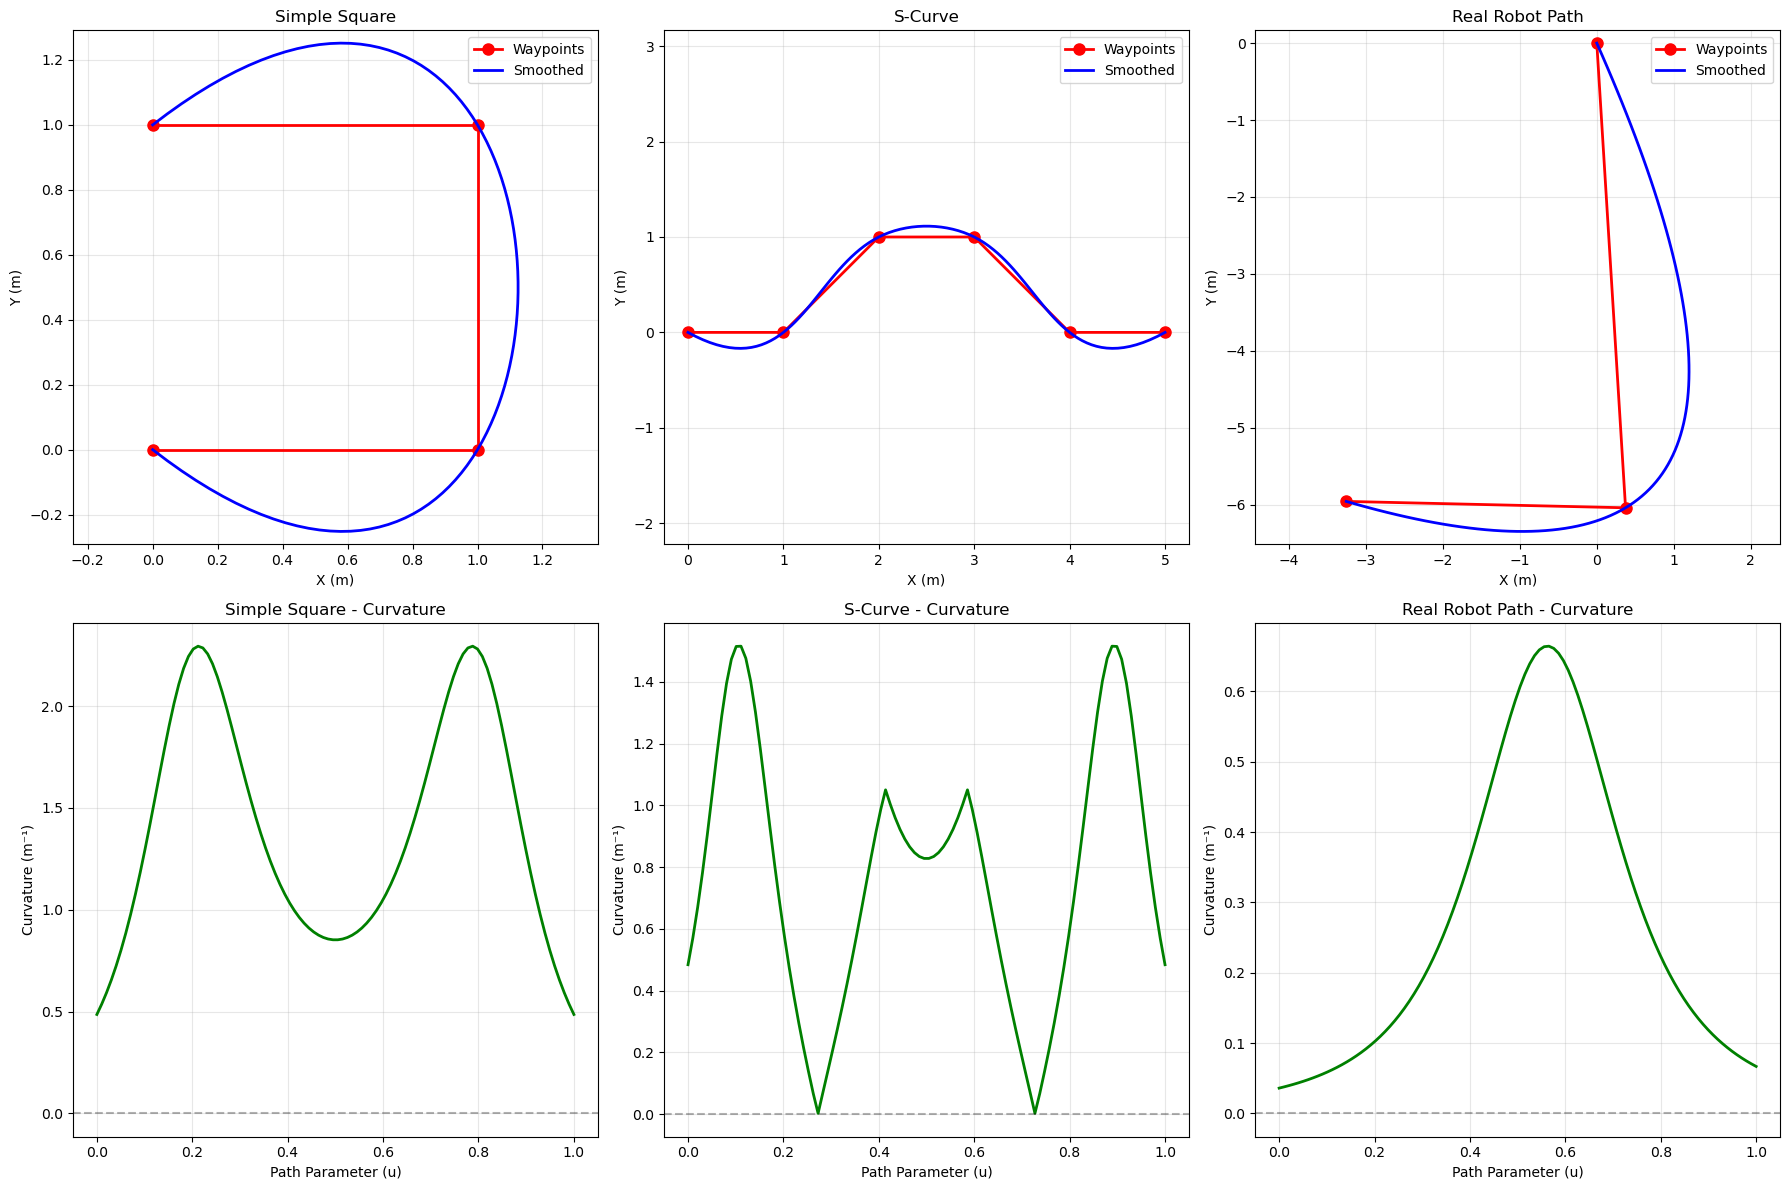


Visual Validation Complete


In [15]:
print("="*60)
print("TEST 6: Visual Validation")
print("="*60)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Test case 1: Simple square
waypoints = fixtures.simple_square()
x_wp = waypoints[:, 0]
y_wp = waypoints[:, 1]
tck, u = splprep([x_wp, y_wp], s=0, k=3)
u_new = np.linspace(0, 1, 100)
x_smooth, y_smooth = splev(u_new, tck)
curvatures = PathSmoother.compute_curvature(tck, u_new)

ax = axes[0, 0]
ax.plot(x_wp, y_wp, 'ro-', label='Waypoints', markersize=8, linewidth=2)
ax.plot(x_smooth, y_smooth, 'b-', label='Smoothed', linewidth=2)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Simple Square')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')

# Test case 2: S-curve
waypoints = fixtures.s_curve()
x_wp = waypoints[:, 0]
y_wp = waypoints[:, 1]
tck, u = splprep([x_wp, y_wp], s=0, k=3)
u_new = np.linspace(0, 1, 100)
x_smooth, y_smooth = splev(u_new, tck)

ax = axes[0, 1]
ax.plot(x_wp, y_wp, 'ro-', label='Waypoints', markersize=8, linewidth=2)
ax.plot(x_smooth, y_smooth, 'b-', label='Smoothed', linewidth=2)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('S-Curve')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')

# Test case 3: Real robot path
waypoints = fixtures.real_robot_path()
x_wp = waypoints[:, 0]
y_wp = waypoints[:, 1]
tck, u = splprep([x_wp, y_wp], s=0, k=2)  # k=2 for 3 points
u_new = np.linspace(0, 1, 100)
x_smooth, y_smooth = splev(u_new, tck)

ax = axes[0, 2]
ax.plot(x_wp, y_wp, 'ro-', label='Waypoints', markersize=8, linewidth=2)
ax.plot(x_smooth, y_smooth, 'b-', label='Smoothed', linewidth=2)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_title('Real Robot Path')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axis('equal')

# Curvature profiles for each test case
test_cases = [
    (fixtures.simple_square(), 'Simple Square', 3),
    (fixtures.s_curve(), 'S-Curve', 3),
    (fixtures.real_robot_path(), 'Real Robot Path', 2)
]

for idx, (waypoints, title, k_val) in enumerate(test_cases):
    x_wp = waypoints[:, 0]
    y_wp = waypoints[:, 1]
    tck, u = splprep([x_wp, y_wp], s=0, k=k_val)
    u_new = np.linspace(0, 1, 100)
    curvatures = PathSmoother.compute_curvature(tck, u_new)
    
    ax = axes[1, idx]
    ax.plot(u_new, curvatures, 'g-', linewidth=2)
    ax.set_xlabel('Path Parameter (u)')
    ax.set_ylabel('Curvature (m⁻¹)')
    ax.set_title(f'{title} - Curvature')
    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color='k', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('bspline_test_results.png', dpi=150, bbox_inches='tight')
print("✓ Visual validation plots created")
print("✓ Plot saved as 'bspline_test_results.png'")
plt.show()

print("\n" + "="*60)
print("Visual Validation Complete")
print("="*60)

# Cell 10: Test Summary Report

In [16]:
print("\n" + "="*70)
print(" "*25 + "TEST SUMMARY REPORT")
print("="*70)

total_tests = 0
passed_tests = 0

for category, tests in test_results.items():
    print(f"\n{category}:")
    print("-" * 70)
    for test in tests:
        status = "✅ PASS" if test['passed'] else "❌ FAIL"
        print(f"  {status}  {test['test']}")
        total_tests += 1
        if test['passed']:
            passed_tests += 1

print("\n" + "="*70)
print(f"TOTAL: {passed_tests}/{total_tests} tests passed ({100*passed_tests/total_tests:.1f}%)")
print("="*70)

# Overall status
if passed_tests == total_tests:
    print("\n🎉 ALL TESTS PASSED! 🎉")
elif passed_tests >= 0.8 * total_tests:
    print("\n⚠️  MOST TESTS PASSED (Some failures)")
else:
    print("\n❌ MULTIPLE TEST FAILURES - Review required")

print("\n" + "="*70)
print("B-SPLINE PATH SMOOTHER TEST SUITE COMPLETE")
print("="*70)



                         TEST SUMMARY REPORT

Path Length:
----------------------------------------------------------------------
  ✅ PASS  Known distance
  ✅ PASS  Single segment
  ✅ PASS  Multi-segment
  ✅ PASS  Zero length

Curvature:
----------------------------------------------------------------------
  ✅ PASS  Straight line
  ✅ PASS  Sharp turn
  ✅ PASS  Continuity
  ✅ PASS  Sign validation

Input Validation:
----------------------------------------------------------------------
  ✅ PASS  Valid waypoints
  ✅ PASS  Insufficient points
  ✅ PASS  Duplicate detection
  ✅ PASS  Collinear points
  ✅ PASS  NaN/Inf detection

Smoothing:
----------------------------------------------------------------------
  ✅ PASS  Waypoint preservation
  ✅ PASS  Point count increase
  ✅ PASS  Sampling rates

Metrics:
----------------------------------------------------------------------
  ✅ PASS  Length relationship
  ✅ PASS  Curvature bounds
  ✅ PASS  Curvature relationship
  ✅ PASS  Smoothness posi